In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import text_hammer as th

In [4]:
emotion_dataset = pd.read_csv('datasets/raw/tweet_emotions.csv')

In [5]:
emotion_dataset.head(5)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [6]:
emotion_dataset.drop(['tweet_id'], axis=1, inplace=True)

In [7]:
emotion_dataset.rename(columns={'content': 'text'}, inplace=True)

Number of rows per star rating:
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


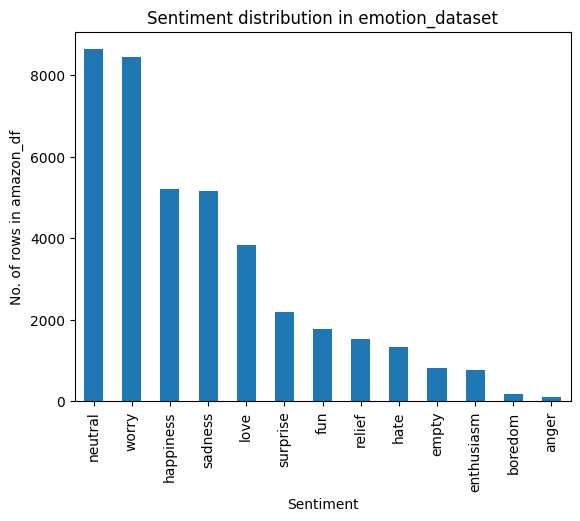

In [8]:
print("Number of rows per star rating:")
print(emotion_dataset['sentiment'].value_counts())

plt.figure()
pd.value_counts(emotion_dataset['sentiment']).plot.bar(title="Sentiment distribution in emotion_dataset")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in amazon_df")
plt.show()

In [9]:
em = emotion_dataset[emotion_dataset.sentiment != 'anger']
em = em[em.sentiment != 'empty']
em = em[em.sentiment != 'boredom']
em = em[em.sentiment != 'enthusiasm']
emotion_dataset = em

In [10]:

def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].apply(lambda x:str(x).lower())
    df[column] = df[column].apply(lambda x: th.cont_exp(x))
    df[column] = df[column].apply(lambda x: th.remove_emails(x))
    df[column] = df[column].apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].apply(lambda x: th.make_base(x))
    return(df)

In [11]:
emotion_dataset = text_preprocessing(emotion_dataset, 'text')

In [12]:
emotion_dataset['sentiment'] = emotion_dataset.sentiment.replace({'fun':0,'happiness':1, 'hate':2, 'love':3, 'neutral':4, 'relief': 5, 'sadness': 6, 'surprise': 7, 'worry': 8})

In [13]:
from collections import defaultdict
import random
def train_val_test(dataframe):
    dictionary = defaultdict(list)
    for index, row in dataframe.iterrows():
        dictionary[row['sentiment']].append(row['text'])
    
    train_size = 70
    val_size = 20
    test_size = 10


    train_set, val_set, test_set = defaultdict(list), defaultdict(list), defaultdict(list)
    for k, v in dictionary.items():
        train_set[k] = v[:int((len(v)*train_size)/100)]
        val_set[k] = v[int((len(v)*train_size)/100):int((len(v)*train_size)/100) + int((len(v)*val_size)/100)]
        test_set[k] = v[int((len(v)*train_size)/100) + int((len(v)*val_size)/100):]
    
    train_vec, val_vec, test_vec = [], [], []

    for k,v in train_set.items():
        for x in v:
            train_vec.append([k, x])
    for k,v in val_set.items():
        for x in v:
            val_vec.append([k, x])
    for k,v in test_set.items():
        for x in v:
            test_vec.append([k, x])

    train_vec = random.sample(train_vec, len(train_vec))
    val_vec = random.sample(val_vec, len(val_vec))
    test_vec = random.sample(test_vec, len(test_vec))
    
    train_df = pd.DataFrame(train_vec, columns=['sentiment', 'text'])
    val_df = pd.DataFrame(val_vec, columns=['sentiment', 'text'])
    test_df = pd.DataFrame(test_vec, columns=['sentiment', 'text'])

    return train_df, val_df, test_df


In [14]:
train_emotion_dataset, val_emotion_dataset, test_emotion_dataset = train_val_test(emotion_dataset)

Number of rows per star rating:
4    8638
8    8459
1    5209
6    5165
3    3842
7    2187
0    1776
5    1526
2    1323
Name: sentiment, dtype: int64


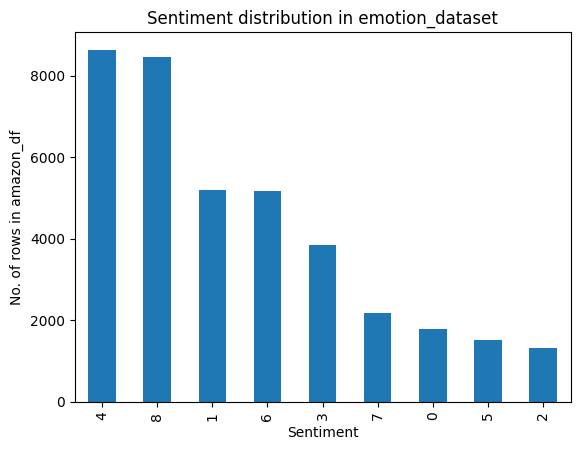

In [15]:
print("Number of rows per star rating:")
print(emotion_dataset['sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(emotion_dataset['sentiment']).plot.bar(title="Sentiment distribution in emotion_dataset")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in amazon_df")
plt.show()

In [16]:
train_emotion_dataset = text_preprocessing(train_emotion_dataset, 'text')
test_emotion_dataset = text_preprocessing(test_emotion_dataset, 'text')
val_emotion_dataset = text_preprocessing(val_emotion_dataset, 'text')

In [17]:
train_emotion_dataset['sentiment'] = train_emotion_dataset.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
test_emotion_dataset['sentiment'] = test_emotion_dataset.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
val_emotion_dataset['sentiment'] = val_emotion_dataset.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [18]:
with open('datasets/processed/train_val_test/train_emotion_dataset.pickle', 'wb') as w:
    pickle.dump(train_emotion_dataset, w)
with open('datasets/processed/train_val_test/val_emotion_dataset.pickle', 'wb') as w:
    pickle.dump(val_emotion_dataset, w)
with open('datasets/processed/train_val_test/test_emotion_dataset.pickle', 'wb') as w:
    pickle.dump(test_emotion_dataset, w)

In [19]:
from keras.utils import to_categorical
y_train = to_categorical(train_emotion_dataset.sentiment.values)
y_test = to_categorical(test_emotion_dataset.sentiment.values)
y_val = to_categorical(val_emotion_dataset.sentiment.values)

In [20]:
from keras.preprocessing.text import Tokenizer 
num_words = 15000 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([train_emotion_dataset['text'], test_emotion_dataset.text], axis = 0)
tokenizer.fit_on_texts(df_total)

In [21]:
with open('models/tokenizer', 'wb') as w:
    pickle.dump(tokenizer, w)

In [22]:
from keras.utils.data_utils import pad_sequences

In [23]:

X_train=tokenizer.texts_to_sequences(train_emotion_dataset['text'])
X_train_pad=pad_sequences(X_train,maxlen= 300,padding='post') 
X_test = tokenizer.texts_to_sequences(test_emotion_dataset.text)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(val_emotion_dataset.text)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [24]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

In [25]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

(15000, 100)

In [26]:
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.key_to_index:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(vector_size)

In [27]:
import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras.layers import Dropout

In [28]:

EMBEDDING_DIM = vector_size
class_num = 9
model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-12 14:32:26.329754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 14:32:26.330043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [30]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/25


2022-12-12 14:32:27.270035: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 14:32:31.626354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:32:32.440290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:32:32.462918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:32:34.053524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:32:34.083887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:32:35.500859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

223/223 [==============================] - ETA: 0s - loss: 1.8918 - accuracy: 0.3070

2022-12-12 14:37:23.570831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:37:23.769801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:37:23.786348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:37:24.681545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:37:24.695098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:37:25.610997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 14:37:25.626022: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_accuracy improved from -inf to 0.31334, saving model to ./model.h5
223/223 [==============================] - 324s 1s/step - loss: 1.8918 - accuracy: 0.3070 - val_loss: 1.8573 - val_accuracy: 0.3133
Epoch 2/25
223/223 [==============================] - ETA: 0s - loss: 1.7863 - accuracy: 0.3521
Epoch 2: val_accuracy improved from 0.31334 to 0.35560, saving model to ./model.h5
223/223 [==============================] - 227s 1s/step - loss: 1.7863 - accuracy: 0.3521 - val_loss: 1.7952 - val_accuracy: 0.3556
Epoch 3/25
223/223 [==============================] - ETA: 0s - loss: 1.7465 - accuracy: 0.3671
Epoch 3: val_accuracy did not improve from 0.35560
223/223 [==============================] - 229s 1s/step - loss: 1.7465 - accuracy: 0.3671 - val_loss: 1.8673 - val_accuracy: 0.3357
Epoch 4/25
223/223 [==============================] - ETA: 0s - loss: 1.7174 - accuracy: 0.3758
Epoch 4: val_accuracy improved from 0.35560 to 0.35665, saving model to ./model.h5
223/223 [=========

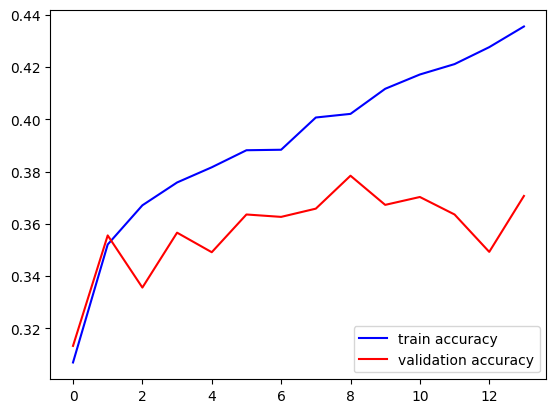

In [31]:
plt.plot(history_embedding.history['accuracy'], c='b', label = 'train accuracy')
plt.plot(history_embedding.history['val_accuracy'], c='r', label = 'validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [32]:
y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

2022-12-12 15:31:27.661248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 15:31:27.865253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 15:31:27.879997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 15:31:28.788130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 15:31:28.799798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 15:31:29.701777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 15:31:29.718150: I tensorflow/core/grappler/optimizers/cust

120/120 [==============================] - 37s 285ms/step
              precision    recall  f1-score   support

           0       0.04      0.24      0.08        33
           1       0.29      0.29      0.29       533
           2       0.06      0.62      0.11        13
           3       0.51      0.35      0.42       561
           4       0.78      0.31      0.44      2180
           5       0.01      0.50      0.03         4
           6       0.17      0.37      0.23       233
           7       0.01      0.29      0.02         7
           8       0.10      0.33      0.15       256

    accuracy                           0.32      3820
   macro avg       0.22      0.37      0.20      3820
weighted avg       0.58      0.32      0.38      3820



In [33]:
model.save_weights('models/RNNLSTM_weights')

In [34]:
model.save('models/RNNLSTM')

INFO:tensorflow:Assets written to: models/RNNLSTM/assets


INFO:tensorflow:Assets written to: models/RNNLSTM/assets
